<a href="https://colab.research.google.com/github/ab17254/ce888/blob/main/Assignment/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: content/data/
  inflating: content/data/arrest_manchester.csv  
  inflating: content/data/data_all.csv  
  inflating: content/data/arrest_london.csv  
  inflating: content/data/arrest_essex.csv  
  inflating: content/data/arrest_wiltshire.csv  
  inflating: content/data/arrest_lancashire.csv  
  inflating: content/data/arrest_suffolk.csv  
  inflating: content/data/arrest_all.csv  


In [3]:
df = pd.read_csv('/content/content/data/data_all.csv')
df

,Unnamed: 0,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,0,2006/07,31.376667,17.333333,60.00,31.8,24.0,23.75,2111,1350,1419,632,134372
1,1,2007/08,33.060000,19.000000,62.75,31.8,26.0,25.75,2231,1371,1525,656,134000
2,2,2008/09,33.770000,20.000000,65.00,31.6,25.5,26.75,2472,1427,1699,689,135651
3,3,2009/10,33.503333,19.666667,65.25,31.6,24.5,26.50,2607,1446,1844,745,135293
4,4,2010/11,33.706667,19.833333,66.75,32.2,24.0,25.75,2582,1442,1838,754,130870
5,5,2011/12,30.876667,17.833333,61.00,29.8,22.0,23.75,2607,1420,1871,766,125579
6,6,2012/13,27.226667,15.833333,52.75,25.8,20.0,21.75,2563,1361,1865,749,121086
7,7,2013/14,26.436667,15.833333,51.75,24.6,19.0,21.00,2665,1352,1922,776,119071
8,8,2014/15,24.833333,14.666667,49.75,23.0,18.0,18.75,2795,1373,2028,785,117757
9,9,2015/16,23.770000,14.000000,48.50,21.6,18.0,16.75,2881,1433,2096,808,114437


In [4]:
data=df.values.T[8]

In [5]:
data

array([2111, 2231, 2472, 2607, 2582, 2607, 2563, 2665, 2795, 2881, 3104,
       3266], dtype=object)

In [6]:
def bootstrap_mean_ci(sample, sample_size, n_bootstraps, ci):
  samples = np.zeros((n_bootstraps, sample_size))
  for i in range(n_bootstraps):
    samples[i] = np.random.choice(sample, sample_size, replace=True)
  data_mean = np.mean(samples)
  n_mean = np.mean(samples, axis=1)
  lower, upper = np.percentile(n_mean, [((100-ci)/2), (100 - (100-ci)/2)])
  return data_mean, lower, upper

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100000.0)

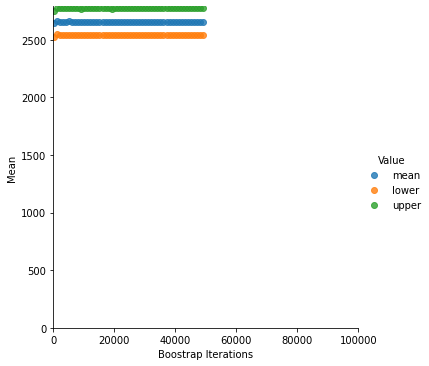

In [7]:
boots = []
for i in range(100, 50000, 1000):
    boot = bootstrap_mean_ci(data, data.shape[0], i, 80)
    boots.append([i, boot[0], "mean"])
    boots.append([i, boot[1], "lower"])
    boots.append([i, boot[2], "upper"])

df_boot = pd.DataFrame(boots, columns=['Boostrap Iterations', 'Mean', "Value"])
sns_plot = sns.lmplot(df_boot.columns[0], df_boot.columns[1], data=df_boot, fit_reg=False, hue="Value")

sns_plot.axes[0, 0].set_ylim(0,)
sns_plot.axes[0, 0].set_xlim(0, 100000)

In [8]:
df.describe()

,Unnamed: 0,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5.500000,28.271111,16.472222,55.645833,26.800000,20.916667,21.520833,2657.000000,1402.583333,1883.416667,754.416667,124381.250000
std,3.605551,5.138060,2.970251,8.951548,5.281873,3.970535,4.739172,326.587313,37.553497,256.182271,67.752837,9342.720337
min,0.000000,19.413333,11.166667,40.500000,18.400000,14.000000,13.000000,2111.000000,1350.000000,1419.000000,632.000000,111506.000000
25%,2.750000,24.567500,14.500000,49.437500,22.650000,18.000000,18.250000,2540.250000,1368.500000,1803.250000,731.000000,116927.000000
50%,5.500000,29.051667,16.583333,56.375000,27.800000,21.000000,22.750000,2607.000000,1422.000000,1868.000000,760.000000,123332.500000
75%,8.250000,33.170833,19.166667,63.312500,31.650000,24.125000,25.750000,2816.500000,1432.250000,2045.000000,790.750000,134093.000000
max,11.000000,33.770000,20.000000,66.750000,32.200000,26.000000,26.750000,3266.000000,1446.000000,2309.000000,852.000000,135651.000000


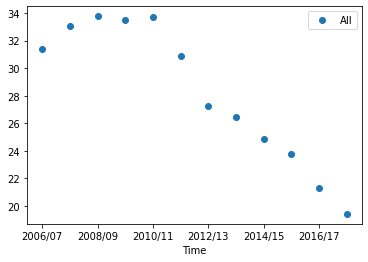

In [9]:
df.plot(x='Time',y='All', style='o')
plt.show()

In [10]:
df['Time'] = df['Time'].str[:-3]

In [11]:
df

,Unnamed: 0,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,0,2006,31.376667,17.333333,60.00,31.8,24.0,23.75,2111,1350,1419,632,134372
1,1,2007,33.060000,19.000000,62.75,31.8,26.0,25.75,2231,1371,1525,656,134000
2,2,2008,33.770000,20.000000,65.00,31.6,25.5,26.75,2472,1427,1699,689,135651
3,3,2009,33.503333,19.666667,65.25,31.6,24.5,26.50,2607,1446,1844,745,135293
4,4,2010,33.706667,19.833333,66.75,32.2,24.0,25.75,2582,1442,1838,754,130870
5,5,2011,30.876667,17.833333,61.00,29.8,22.0,23.75,2607,1420,1871,766,125579
6,6,2012,27.226667,15.833333,52.75,25.8,20.0,21.75,2563,1361,1865,749,121086
7,7,2013,26.436667,15.833333,51.75,24.6,19.0,21.00,2665,1352,1922,776,119071
8,8,2014,24.833333,14.666667,49.75,23.0,18.0,18.75,2795,1373,2028,785,117757
9,9,2015,23.770000,14.000000,48.50,21.6,18.0,16.75,2881,1433,2096,808,114437


In [27]:
df.iloc[:, 8:]

,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,2111,1350,1419,632,134372
1,2231,1371,1525,656,134000
2,2472,1427,1699,689,135651
3,2607,1446,1844,745,135293
4,2582,1442,1838,754,130870
5,2607,1420,1871,766,125579
6,2563,1361,1865,749,121086
7,2665,1352,1922,776,119071
8,2795,1373,2028,785,117757
9,2881,1433,2096,808,114437


In [28]:
X = df.iloc[:, 8:].values
y = df.iloc[:, 2].values

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
print(regressor.intercept_)
print(regressor.coef_)

-51.874308986008934
[-0.02024371  0.01140086  0.01684524  0.0297801   0.00051221]


In [33]:
y_pred = regressor.predict(X_test)

In [34]:
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dataset

,Actual,Predicted
0,27.226667,27.501173
1,19.413333,19.627733
2,33.706667,32.745587


In [35]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.48332871082526313
Mean Squared Error: 0.34833185645750714
Root Mean Squared Error: 0.5901964558157793
